In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from pathlib import Path
import os

%matplotlib inline
plt.rcParams['figure.figsize'] = (12,5)
cwd=os.getcwd()

In [6]:
path_hu = cwd + '/data/hubel.dat'
hub_file = Path(path_hu)
if hub_file.is_file():
    hub = np.genfromtxt(path_hu)
    z_obs = hub[:,0]
    H_obs = hub[:,1]
    dH_obs = hub[:,2]
    print("Hubble data are loaded")
    
else:
    print("Hubble files do not exist")
    sys.exit(0) 


cov_mat_sta = np.zeros((len(z_obs),len(z_obs)))

for i in range(len(z_obs)):
    cov_mat_sta[i][i] = cov_mat_sta[i][i] + pow(dH_obs[i],2)

cov_mat_sta_inv = np.linalg.inv(cov_mat_sta)


Hubble data are loaded


In [7]:
def Hubble_the(z,H0,omega_m):
    matter=(omega_m)*pow(1.+z,3)
    omega_DE = 1. - omega_m
    DE=omega_DE
    return H0*pow(matter + DE,0.5)


def xi2_h(H0,om):
    H_th = Hubble_the(z_obs,H0,om)
    x = ( H_th - H_obs)/dH_obs 
    return pm.math.dot(x,x)  

def log_likelihood(H0,om):
    return -0.5*( xi2_h(H0,om)  )    

In [19]:
import theano.tensor as t
import theano
import pymc3 as pm

with pm.Model() as model: # model specifications in PyMC3 are wrapped in a with-statement
    # Define priors
    om = pm.Uniform('Omega_m', lower=0.1, upper=0.4)
    H0 = pm.Uniform('H0', lower=60, upper=80)
    
    like = pm.Potential('like', log_likelihood(H0,om))

    #step = pm.Metropolis()
    #step= None
    #step = pm.hmc.HamiltonianMC()
    # Inference!
    trace = pm.sample(15000,tune=1500, cores=2,chains=2,step=step)   

Initializing SMC sampler...
Sampling 2 chains in 2 jobs
Stage:   0 Beta: 0.029
Stage:   1 Beta: 0.122
Stage:   2 Beta: 0.415
Stage:   3 Beta: 1.000
Stage:   0 Beta: 0.029
Stage:   1 Beta: 0.122
Stage:   2 Beta: 0.420
Stage:   3 Beta: 1.000


           mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Omega_m   0.237  0.015   0.210    0.266      0.000    0.000   19887.0   
H0       72.068  1.044  70.131   74.085      0.007    0.005   20188.0   

          ess_sd  ess_bulk  ess_tail  r_hat  
Omega_m  19887.0   19879.0   19813.0    1.0  
H0       20188.0   20186.0   19903.0    1.0  
xi2_best = 30.59479281907578
om_best = 0.2365966572819902
H0_best = 72.06766857590333


array([[<AxesSubplot:title={'center':'Omega_m'}>,
        <AxesSubplot:title={'center':'Omega_m'}>],
       [<AxesSubplot:title={'center':'H0'}>,
        <AxesSubplot:title={'center':'H0'}>]], dtype=object)

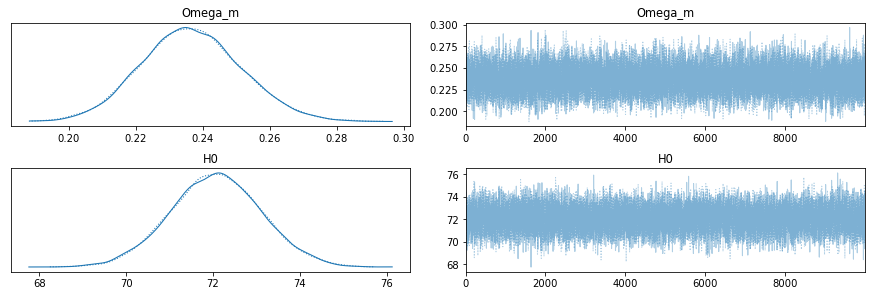

In [20]:
logp = model.logp
lnp = np.array([logp(trace.point(i,chain=c)) for c in trace.chains for i in range(len(trace))])
xi2_best = np.amin(-2*lnp)
om_best = np.mean(trace['Omega_m'])
H0_best = np.mean(trace['H0'])
print(pm.summary(trace))
print("xi2_best =",xi2_best)
print("om_best =",om_best)
print("H0_best =",H0_best)
pm.traceplot(trace)